In [5]:
# John Royal
# CSc 44800: Artificial Intelligence - Final Project

# Constants for the K-Means algorithm.
# These numbers are the same for both implementations.
# You may want to reduce these numbers to speed up the algorithm.

N_CLUSTERS = 10  # One cluster for each digit.
N_INIT = 10  # Run the algorithm 10 times and choose the best result.
MAX_ITER = 100  # Run the algorithm at most 100 times.
RANDOM_STATE = 0  # Set the random seed for reproducibility.

In [6]:
# Import external dependencies.
from sklearn.cluster import KMeans as SklearnKMeans
from time import time
from concurrent.futures import ThreadPoolExecutor

# Import internal dependencies.
from load import MNISTRawData
from preprocess import MNISTPreprocessedData
from kmeans import KMeans
from analysis import (
    get_predicted_labels,
    compute_confusion_matrix,
    plot_confusion_matrix,
)

In [7]:
def run_with_scikit_learn():
    """
    Runs the K-Means algorithm using the scikit-learn implementation.
    """
    sklearn_kmeans = SklearnKMeans(
        n_clusters=N_CLUSTERS,
        n_init=N_INIT,
        max_iter=MAX_ITER,
        random_state=RANDOM_STATE,
    )
    return test_kmeans("sklearn", sklearn_kmeans)


def run_with_kmeans_from_scratch():
    """
    Runs the K-Means algorithm using the implementation from scratch.
    """
    kmeans = KMeans(
        n_clusters=N_CLUSTERS,
        n_init=N_INIT,
        max_iter=MAX_ITER,
        random_state=RANDOM_STATE,
    )
    return test_kmeans("scratch", kmeans)


def test_kmeans(title: str, kmeans: KMeans):
    """
    Contains the logic for testing a K-Means model, used to test both the
    scikit-learn implementation and the implementation from scratch. This includes:
    1. Loading the data.
    2. Preprocessing the data.
    3. Fitting the model to the training data.
    4. Predicting clusters for the testing data.
    5. Analyzing and computing the confusion matrix.
    """
    start_time = time()

    print(f"[{title}] Loading data...")

    raw_training_data = MNISTRawData.load_training_data()
    raw_testing_data = MNISTRawData.load_testing_data()

    print(f"[{title}] Preprocessing data...")

    training_data = MNISTPreprocessedData.from_raw_data(raw_training_data).augmented()
    testing_data = MNISTPreprocessedData.from_raw_data(raw_testing_data)

    print(f"[{title}] Fitting model to training data...")

    kmeans.fit(training_data.images)

    print(
        f"[{title}] Training finished in {time() - start_time:.2f} seconds, continuing to analyze with testing data..."
    )

    predicted_clusters = kmeans.predict(testing_data.images)

    print(f"[{title}] Analyzing and computing confusion matrix...")

    predicted_labels, cluster_labels = get_predicted_labels(
        predicted_clusters, testing_data.labels
    )
    confusion_matrix = compute_confusion_matrix(testing_data.labels, predicted_labels)

    print(f"[{title}] Finished in {time() - start_time:.2f} seconds.")

    return confusion_matrix, testing_data.labels, predicted_labels

[sklearn] Loading data...
[scratch] Loading data...
[sklearn] Preprocessing data...
[scratch] Preprocessing data...
[sklearn] Fitting model to training data...
[scratch] Fitting model to training data...
[sklearn] Training finished in 155.65 seconds, continuing to analyze with testing data...
[sklearn] Analyzing and computing confusion matrix...
  Cluster 0 (Most Common Digit: 0) - Accuracy: 0.78
  Cluster 1 (Most Common Digit: 1) - Accuracy: 0.66
  Cluster 2 (Most Common Digit: 1) - Accuracy: 0.53
  Cluster 3 (Most Common Digit: 6) - Accuracy: 0.86
  Cluster 4 (Most Common Digit: 8) - Accuracy: 0.53
  Cluster 5 (Most Common Digit: 4) - Accuracy: 0.37
  Cluster 6 (Most Common Digit: 3) - Accuracy: 0.53
  Cluster 7 (Most Common Digit: 7) - Accuracy: 0.43
  Cluster 8 (Most Common Digit: 0) - Accuracy: 0.91
  Cluster 9 (Most Common Digit: 2) - Accuracy: 0.89
[sklearn] Finished in 155.67 seconds.


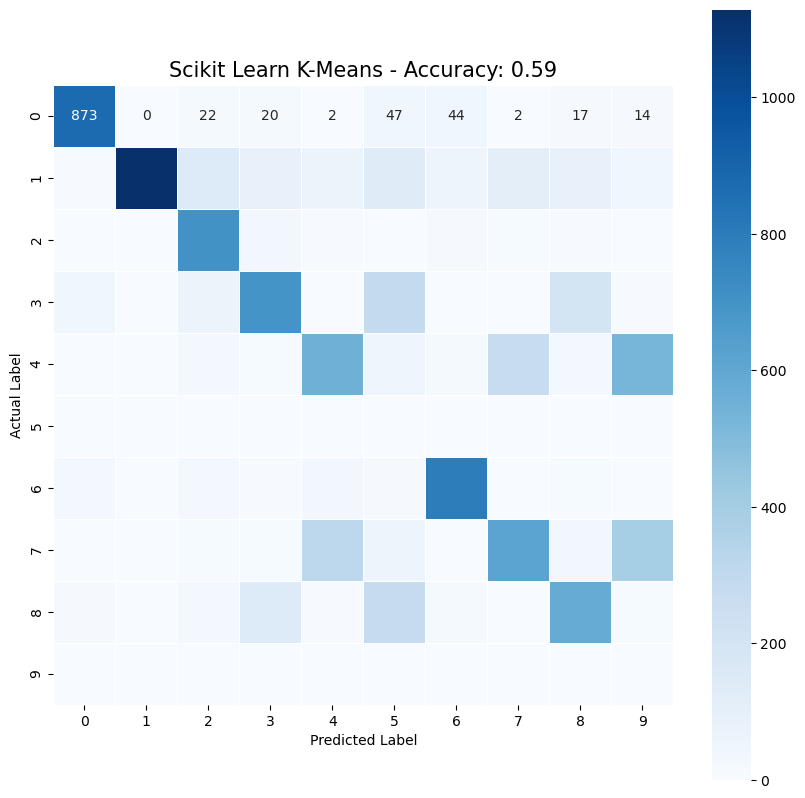

[scratch] Training finished in 897.64 seconds, continuing to analyze with testing data...
[scratch] Analyzing and computing confusion matrix...
  Cluster 0 (Most Common Digit: 1) - Accuracy: 0.71
  Cluster 1 (Most Common Digit: 1) - Accuracy: 0.58
  Cluster 2 (Most Common Digit: 7) - Accuracy: 0.41
  Cluster 3 (Most Common Digit: 3) - Accuracy: 0.50
  Cluster 4 (Most Common Digit: 2) - Accuracy: 0.90
  Cluster 5 (Most Common Digit: 9) - Accuracy: 0.37
  Cluster 6 (Most Common Digit: 8) - Accuracy: 0.44
  Cluster 7 (Most Common Digit: 0) - Accuracy: 0.93
  Cluster 8 (Most Common Digit: 4) - Accuracy: 0.42
  Cluster 9 (Most Common Digit: 6) - Accuracy: 0.85
[scratch] Finished in 897.71 seconds.


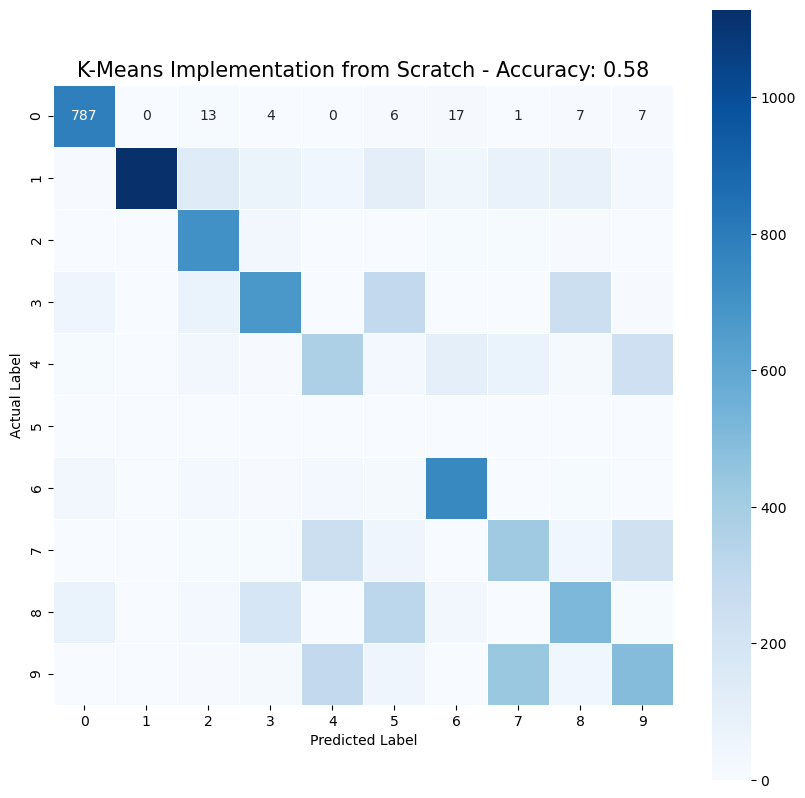

In [8]:
# The __name__ == "__main__" check is necessary to prevent infinite loops caused by the ThreadPoolExecutor.

if __name__ == "__main__":
    # Run both implementations in parallel.

    with ThreadPoolExecutor() as executor:
        # Enqueue both implementations.
        sklearn_result_future = executor.submit(run_with_scikit_learn)
        scratch_result_future = executor.submit(run_with_kmeans_from_scratch)

        # Await and plot the sklearn implementation first because it's faster.
        sklearn_result = sklearn_result_future.result()
        plot_confusion_matrix(
            "Scikit Learn K-Means",
            cm=sklearn_result[0],
            test_labels=sklearn_result[1],
            predicted_labels=sklearn_result[2],
        )

        # Await and plot the scratch implementation.
        scratch_result = scratch_result_future.result()
        plot_confusion_matrix(
            "K-Means Implementation from Scratch",
            cm=scratch_result[0],
            test_labels=scratch_result[1],
            predicted_labels=scratch_result[2],
        )
